In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import feature, io, color
from skimage import io
import skimage

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#drive.mount("/content/gdrive", force_remount=True)

## Import data

In [3]:
# Honey bee as 0.0
# Bumble bee as 1.0
#labels= pd.read_csv(open('/content/gdrive/My Drive/Assignment/dataset/labels.csv'))

labels = pd.read_csv('dataset/labels.csv', index_col=0)
labels.head()

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3969 entries, 520 to 2636
Data columns (total 1 columns):
genus    3969 non-null float64
dtypes: float64(1)
memory usage: 62.0 KB


In [5]:
labels['genus'].value_counts()

1.0    3142
0.0     827
Name: genus, dtype: int64

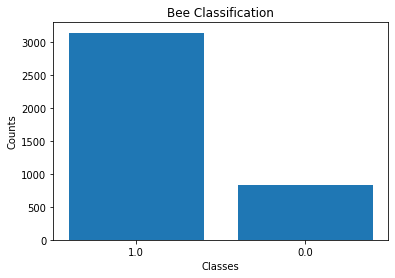

In [6]:
unique_values = labels['genus'].unique()
x_pos = np.arange(len(unique_values))
plt.bar(x_pos, labels['genus'].value_counts())
plt.xticks(x_pos, unique_values)
plt.ylabel('Counts')
plt.xlabel('Classes')
plt.title('Bee Classification')

plt.show()

In [7]:
#def get_image(row_id, root='/content/gdrive/My Drive/Assignment/dataset/images'):
def get_image(row_id, root='dataset/images/'):
    #print(row_id)
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = io.imread(file_path)
    img = color.rgb2gray(img)
    img = skimage.transform.rescale(img, 1)

    return img

In [9]:
#labels['id']

In [11]:
images = []
for i in labels.genus.index:
    images.append(get_image(i))

In [12]:
len(images)

3969

In [13]:
images[0].shape

(200, 200)

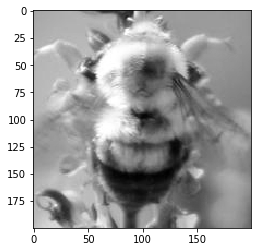

In [14]:
plt.imshow(images[7], cmap='gray')

In [15]:
labels.genus.index

Int64Index([ 520, 3800, 3289, 2695, 4922, 1934, 3704, 4017, 3331,  173,
            ...
            3208, 1259, 3573,   49, 2365, 4743, 2787, 3081,  128, 2636],
           dtype='int64', name='id', length=3969)

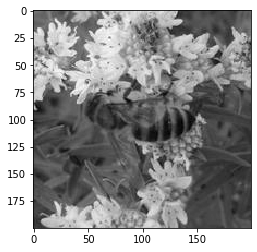

In [16]:
# Visualize Honey Bee
honey_bee_row = labels[labels.genus==0.0].index[5]
honey_bee = get_image(honey_bee_row)
plt.imshow(honey_bee, cmap = 'gray')

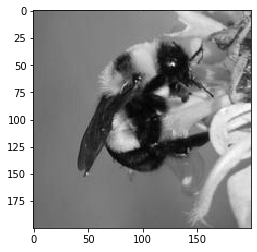

In [17]:
# Visualize Bumblee Bee

bumblee_bee_row = labels[labels.genus==1.0].index[5]
bumblee_bee = get_image(bumblee_bee_row)
plt.imshow(bumblee_bee, cmap = 'gray')

In [18]:
# Extract HOG features

In [ ]:
X = []
for img in images:
    fp = feature.hog(img)
    X.extend(fp)
    

In [0]:
X = np.asarray(X)

In [21]:
X.shape

(32148900,)

In [0]:
y = labels['genus']

In [23]:
y[0:5]

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: genus, dtype: float64

In [24]:
len(X),len(y)

(32148900, 3969)

In [0]:

X = X.reshape((3969,8100))

In [26]:
X.shape

(3969, 8100)

# PCA

In [0]:
from sklearn.decomposition import PCA
from scipy.linalg import eigh

In [0]:
covariance_matrix = (X).T.dot((X)) / (X.shape[0])
eigen_vals, eigen_vects = eigh(covariance_matrix)
idx=eigen_vals.argsort()[::-1]
eigen_vals=eigen_vals[idx]
eigen_vects = eigen_vects[:,idx]

In [29]:
eigen_vects.shape

(8100, 8100)

<function matplotlib.pyplot.show>

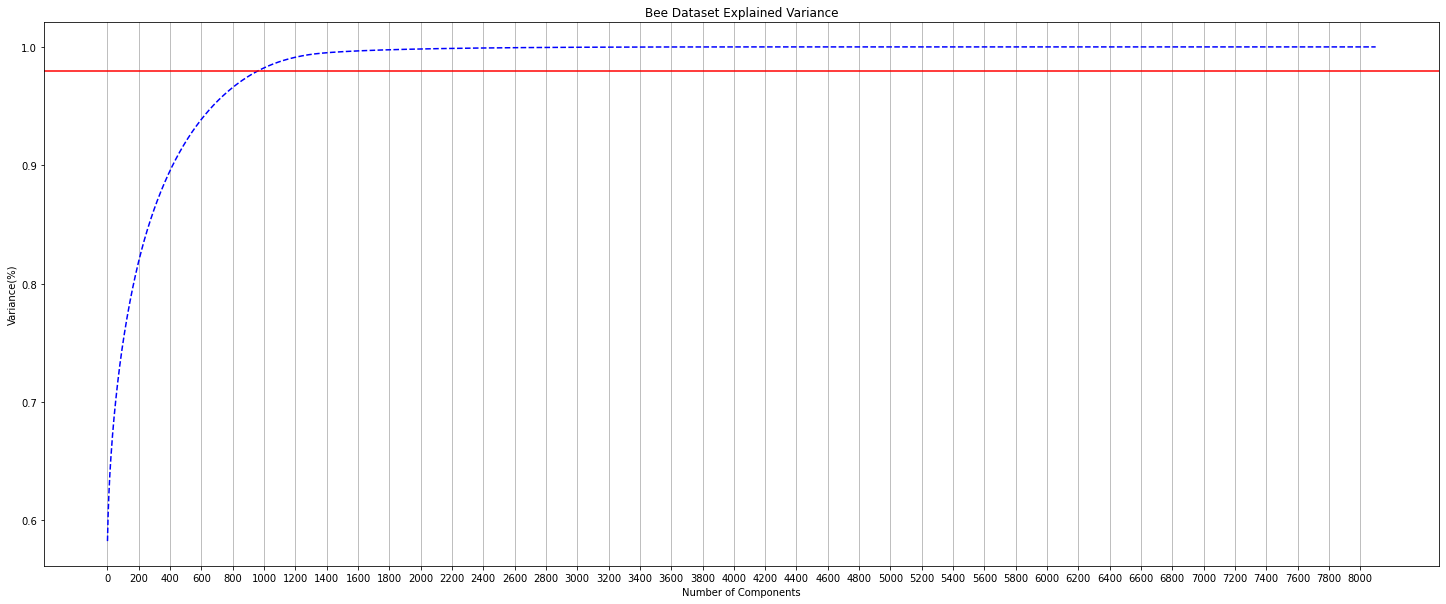

In [30]:
explained_variance = [np.abs(i)/np.sum(eigen_vals) for i in eigen_vals]
total_variance = np.cumsum(explained_variance)
plt.figure(figsize=(25,10))
plt.plot(total_variance,linestyle='--',color='b')
plt.xticks(np.arange(0,8100,step=200))
plt.xlabel('Number of Components')
plt.ylabel('Variance(%)')
plt.title('Bee Dataset Explained Variance')
plt.axhline(y=0.98,color = 'r',linestyle='-')
plt.grid(axis='x')
plt.show

In [0]:
pca = PCA(n_components=1000)
pca.fit(X)
X = pca.transform(X)

In [32]:
X.shape

(3969, 1000)

# Train Test split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train,X_test, y_train, y_test =train_test_split(X, y,stratify=y,test_size=0.25,random_state=27)

# Model, GridSearch and it's Evalution

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, f1_score

In [0]:
def grid_search_classifier(classifier_class, train_x,train_y,test_x,test_y,grid_params):
    print(classifier)
    scorer = make_scorer(f1_score, average = 'macro')
    clf = GridSearchCV(classifier_class(random_state=1),
                      grid_params, scoring = scorer)
    
    clf.fit(train_x,train_y)
    print(clf.best_score_, clf.best_params_)
    
    best_model = classifier_class(**clf.best_params_)
    best_model.fit(train_x, train_y)
    y_preds_final = best_model.predict(test_x)
    f1Score= f1_score(test_y,y_preds_final,average='macro')
    return f1Score

In [0]:
classifiers_to_try_out = [
    (RandomForestClassifier,
    {'n_estimators': [5,10,20,50],'criterion':['gini','entropy'],'max_depth':[3,7,15,19,21,23,25],'min_samples_split':[2,4,6,8,10]}
    ),
    (SVC,
    {'C':[0.1,1,10,100,1000], 'kernel':['linear','rbf','sigmoid'],'gamma':[1,0.1,0.01,0.001,0.0001]}
    ),
    (AdaBoostClassifier,
    {'n_estimators': [5,10,20], 'learning_rate':[1,0.5,0.25,0.1,0.01]}
    )
]

In [0]:
#f1Scores=[]
#for classifier, grid in classifiers_to_try_out:
#    f1Score = grid_search_classifier(classifier, X_train, y_train,X_test,y_test, grid)
#    f1Scores.append({'Classifier': str(classifier),'F1-Score':f1Score})
    
#print(accuracies)
#classwisef1Score = pd.DataFrame(f1Scores)

In [0]:
#classwisef1Score

# Final Model

In [98]:
model = SVC(C = 1, gamma=1, kernel='linear')
model.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
import pickle

In [0]:
file_name = 'model.pkl'
pickle.dump(model, open(file_name, 'wb'))

In [0]:
file_name = 'model.pkl'
model = pickle.load(open(file_name, 'rb'))

In [44]:
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.25      0.27      0.26       207
         1.0       0.80      0.79      0.80       786

    accuracy                           0.68       993
   macro avg       0.53      0.53      0.53       993
weighted avg       0.69      0.68      0.68       993



# Model usage on 3 examples.

In [0]:
import skimage

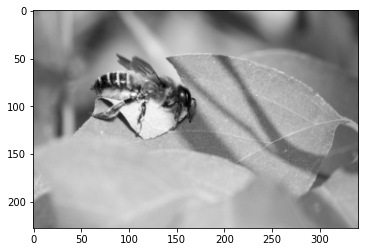

In [261]:
test_image = io.imread('/content/gdrive/My Drive/Assignment/dataset/beee.jpg')
test_image = color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 1/3)

plt.imshow(test_image, cmap = 'gray')

In [0]:
def sliding_window(image, patch_size=(60,40), istep = 2, jstep = 2):
    indices = []
    patches = []
    
    Ni, Nj = patch_size
    
    for i in range(0, image.shape[0] - Ni, istep):
        for j in range(0, image.shape[1] -Nj, jstep):
            patch = image[i:i + Ni, j:j +Nj]
            indices.append((i,j))
            patches.append(patch)
            
    return indices, patches
indices, patches = sliding_window(test_image)

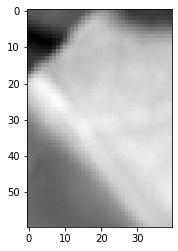

In [263]:
plt.imshow(patches[-1], cmap = 'gray')

In [0]:
patch_hog = []

for img in patches:
    f_hog = feature.hog(img)
    patch_hog.append(f_hog)

In [0]:
pca = PCA(n_components=1000)
pca.fit(patch_hog)
patch_hog = pca.transform(patch_hog)

In [0]:
labels = model.predict(patch_hog)

In [267]:
len(labels)

12684

In [268]:
sum(labels)

12639.0

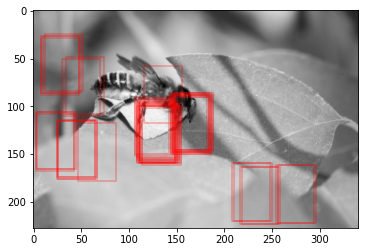

In [269]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap = 'gray')

Ni, Nj = (60,40)

indices = np.array(indices)

for i,j in indices[labels == 0]:
    ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor = 'red', alpha = 0.3, lw = 1.5, facecolor = 'none'))